# Lets import some things

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import time
from torchsummary import summary
import scipy.io

In [17]:
mat = scipy.io.loadmat('data/flowers-102/imagelabels.mat')
print(len(mat['labels'][0])) #it turns out the image labels are numbers and i cant recognise flowers by eye. nvm i found someone helpful online

8189


# I found a text file with the classnames

In [18]:
names = [ 'pink primrose','hard-leaved pocket orchid','canterbury bells','sweet pea','english marigold','tiger lily','moon orchid','bird of paradise','monkshood','globe thistle','snapdragon',"colt's foot",'king protea','spear thistle','yellow iris','globe-flower','purple coneflower','peruvian lily','balloon flower','giant white arum lily','fire lily','pincushion flower','fritillary','red ginger','grape hyacinth','corn poppy','prince of wales feathers','stemless gentian','artichoke','sweet william','carnation','garden phlox','love in the mist','mexican aster','alpine sea holly','ruby-lipped cattleya','cape flower','great masterwort','siam tulip','lenten rose','barbeton daisy','daffodil','sword lily','poinsettia','bolero deep blue','wallflower','marigold','buttercup','oxeye daisy','common dandelion','petunia','wild pansy','primula','sunflower','pelargonium','bishop of llandaff','gaura','geranium','orange dahlia','pink-yellow dahlia?','cautleya spicata','japanese anemone','black-eyed susan','silverbush','californian poppy','osteospermum','spring crocus','bearded iris','windflower','tree poppy','gazania','azalea','water lily','rose','thorn apple','morning glory','passion flower','lotus','toad lily','anthurium','frangipani','clematis','hibiscus','columbine','desert-rose','tree mallow','magnolia','cyclamen ','watercress','canna lily','hippeastrum ','bee balm','ball moss','foxglove','bougainvillea','camellia','mallow','mexican petunia','bromelia','blanket flower','trumpet creeper','blackberry lily']

# Decide if cuda

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda


# Load dataset

In [20]:
trainingData = datasets.Flowers102(
    root="data",
    split = "train",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomResizedCrop((224, 224),antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), 
        # transforms.ColorJitter(contrast=0.08,brightness=0.08, saturation=0.08,hue=0.02),#becaise the dataset will evidently be sensitve to colour might want to avoid this one
        transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1),shear=0.15),
        transforms.GaussianBlur(kernel_size=(3,3),sigma=(0.1,2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.43554732, 0.37773556, 0.28792068], [0.26202053, 0.20857088, 0.21565172])
    ])
)
testData = datasets.Flowers102(
    root="data",
    split= "test",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.43554732, 0.37773556, 0.28792068], [0.26202053, 0.20857088, 0.21565172])
    ])
)
valData = datasets.Flowers102(
    root="data",
    split = "val",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.43554732, 0.37773556, 0.28792068], [0.26202053, 0.20857088, 0.21565172])
    ])
)

C:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [21]:
print(f'training data has: {len(trainingData)} images')
print(f'validation data has: {len(valData)} images')
print(f'test data has: {len(testData)} images')

training data has: 1020 images
validation data has: 1020 images
test data has: 6149 images


# Neural Network class

In [22]:
class NeuralNet(nn.Module):
    def __init__(self,num_classes):
        super(NeuralNet, self).__init__()
        self.features = nn.Sequential(
            #conv1
            nn.Conv2d(3,32,kernel_size=3,padding=1),#it is my understanding that batch norm means that i need not use bias which is the default
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2),#128x128
            #conv2
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#64x64
            nn.Dropout(0.2),
            #conv3
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#32x32
            nn.Dropout(0.2),
            #conv4
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#16x16
            nn.Dropout(0.2),
            #conv5
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#8x8
            nn.Dropout(0.2)
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3), #you can apply more aggresive dropout in these full connected layers since units will be less relied upon
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024,num_classes),
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        x= self.features(x)
        x= self.global_avg_pool(x)
        x= x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

# Training loop

In [23]:
def train(model, train_dataloader, val_dataloader, num_epochs, learning_rate, device):
    cost = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    
    loss_per_epoch = [] # clear all data incase retraining
    val_epochs = []
    tra_epochs = []
    quit_early_counter = 0
    last_epoch_loss = None
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        batches = 0
        
        for i, (images,labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = cost(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() #so this line is a sync point for the cpu and gpu commenting it out greatly reduces the training time (up to 25%  in my testing)
            batches +=1
        
        avg_loss = running_loss / batches
        loss_per_epoch.append(avg_loss)
        
        val_acc,val_avg_loss = evaluate(model=model,dataloader=val_dataloader,device=device,cost=cost)
        val_epochs.append(val_acc)
        tra_acc, train_avg_loss = evaluate(model=model,dataloader=train_dataloader,device=device,cost=cost)
        tra_epochs.append(tra_acc)
        # scheduler.step(val_loss)
        
        if last_epoch_loss is not None and abs(last_epoch_loss - avg_loss)<0.01:
            quit_early_counter += 1
        else:
            quit_early_counter = 0
        last_epoch_loss = avg_loss
        
        epoch_length = time.time() - epoch_start
        # print(f'\n Last lr {float(scheduler.get_last_lr()[0])}, Epoch: {epoch+1}')
        print(f'Epoch: {epoch+1}, Avg Loss: {avg_loss:4f}, Num Batches: {batches}, Epoch Time: {epoch_length:.2f}, Validation Acc: {val_acc:.3f}%, Training Acc: {tra_acc:.3f}%')
        
        if quit_early_counter >= 5:
            print('val acc isnt improving over last 5 so stop training')
            break
        if tra_acc >=99.2:
            print('You converged to 99.2% on training data, its worth stopping here')
            break            
    return np.array(loss_per_epoch), np.array(val_epochs), np.array(tra_epochs)

# Plot the avg loss against epochs

In [24]:
def plot_array(array,name):
    plt.plot(array, label=f'{name}')
    # plt.plot(validation_epoch_losses,label='Validation Loss')   
    plt.legend()
    plt.show()

# Display the training, testing, validation accuracy

In [25]:
def evaluate(model, dataloader, device, cost):
    model.eval()
    correct = 0
    total =0
    total_loss =0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            total_loss += loss.item() *labels.size(0)
        acc= 100 *correct/total
        avg_loss = total_loss/total
    return acc, avg_loss

# evaluate on test, validation and training data

In [26]:
def all_eval(model, device, cost):
    accval, _= evaluate(model=model,dataloader=val_dataloader,device=device,cost=cost)
    print(f'val acc: {accval:.3f}%')
    acctest, _ = evaluate(dataloader=test_dataloader,model=model,cost=cost,device=device)
    print(f'test acc: {acctest:.3f}%')
    trainacc, _ = evaluate(dataloader=train_dataloader,model=model,cost=cost,device=device)
    print(f'train acc: {trainacc:.3f}%')

# Save model

In [27]:
def save(model, pathname):
    torch.save(model.state_dict(), f'{pathname}.pth')
    print(f'Saved model to {pathname}.pth')

# Load model

In [28]:
def load(model, pathname ,device):
    model.load_state_dict(torch.load(f'{pathname}.pth'))
    model.to(device)
    print(f'Loaded model from {pathname}.pth')

# Visualise samples

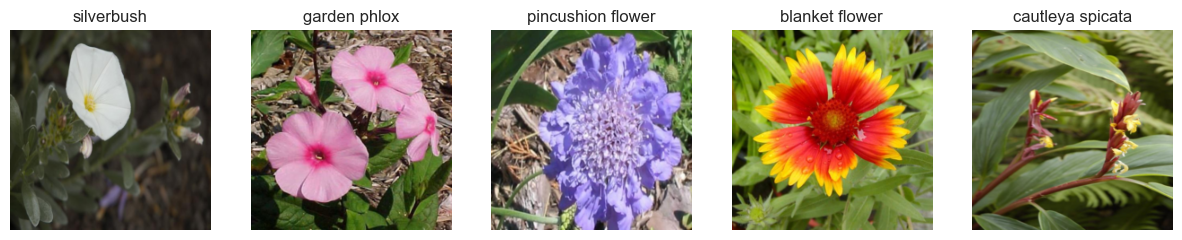

In [29]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        # Randomly select a sample from the dataset
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_idx]

        # Denormalize the image idk  if this is neccesary
        image = image * torch.tensor([0.26202053, 0.20857088, 0.21565172]).view(3, 1, 1) + torch.tensor([0.43554732, 0.37773556, 0.28792068]).view(3, 1, 1)
        
        # Plot the image
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f'{names[label]}')
        axes[i].axis('off')

    plt.show()

# Visualize samples from the test dataset
visualize_samples(testData)

# main loop

In [ ]:
if __name__ == '__main__':
    BATCH_SIZE = 48
    NUM_CLASSES = 102
    LEARNING_RATE = 0.003   #0.006 works for 32
    NUM_EPOCHS = 250
    
    train_dataloader = DataLoader(trainingData, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, prefetch_factor=4,persistent_workers=True)
    test_dataloader = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, prefetch_factor=2,persistent_workers=True)
    val_dataloader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,prefetch_factor=2,persistent_workers=True)
    # 
    model = NeuralNet(NUM_CLASSES).to(device)
    # summary(model,input_size=(3,224,224))
    training_epoch_losses, val_acc_per, tra_acc_per = train(model=model,train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=device)
    # 
    # 
    plot_array(training_epoch_losses,'training epoch losses')
    plot_array(val_acc_per,'validation accuracy per epoch')
    plot_array(tra_acc_per,'training accuracy per epoch')
    all_eval(model=model,device=device,cost=torch.nn.CrossEntropyLoss())

# runs a command that converts this notebook to a py script

In [ ]:
def convert():
    !jupyter nbconvert --to script Classifier.ipynb

In [ ]:
convert()

# todo possibly do the image display thing/ https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html / tune hyperparams

# Sanity checking